## Classify RNA-Seq + ATAC-Seq by Cell type

In [4]:
# import needed modules:

# general python utilities
import os
import platform
import random
import shutil
import sys
import time
import datetime
import functools
import itertools as it
import copy

# recommended Python3 version >= 3.5
print('Python version: {}'.format(platform.sys.version))

# data-science & processing tools
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import h5py
import scanpy as sc
import anndata as ann

# progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm_notebook as tqdm

# plotting utilities
import seaborn as sns
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
import tensorflow.keras as K

# required TensorFlow version >= 2.0.0
tf_version = tf.__version__
print('TensorFlow version: {}'.format(tf_version))
assert int(tf_version[0]) >= 2, "Tensorflow version must be >= 2.0"

# seed random numbers for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print('\nImports Complete.')

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) 
[Clang 9.0.1 ]
TensorFlow version: 2.1.0

Imports Complete.


In [5]:
# make some fake data until real data becomes available
n_samples, n_rna_features, n_atac_features = 6000, 500, 100
rna_seq_fake = np.random.rand(n_samples, n_rna_features)
atac_seq_fake = np.random.rand(n_samples, n_atac_features)
X_np = np.concatenate([rna_seq_fake, atac_seq_fake], axis=1)
Y_np = np.array(['cell_type_A'] * 2000 + ['cell_type_B'] * 2000 + ['cell_type_C'] * 2000)

In [6]:
# make one-hot encoding of cell type classes
le = LabelEncoder()
Y_le = le.fit_transform(Y_np)
tf.one_hot(Y_le, depth=3)

<tf.Tensor: shape=(6000, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [53]:
''' Load in matrices generated after pre-processing steps '''
PATH = os.getcwd() # make sure cwd is 6_874-Multimodal-DL
OUTPUTS = os.path.join(PATH, 'Outputs')
atac_data_path = os.path.join(OUTPUTS, 'atacRaw')
rna_data_path = os.path.join(OUTPUTS, 'rnaRaw')
bimodal_data_path = os.path.join(OUTPUTS, 'bimodalRaw')
bim_low_data_path = os.path.join(OUTPUTS, 'bimodalLowDim_ScAi')

# save as pandas dataframes
atac_df = pd.read_hdf(atac_data_path)
rna_df = pd.read_hdf(rna_data_path)
bimodal_df = pd.read_hdf(bimodal_data_path)
bi_low_df = pd.read_hdf(bim_low_data_path)

In [54]:
atac_df.head()

Unnamed: 0,sample,treatTime,1-9963-10665,1-360366-360566,1-525043-525243,1-534190-534416,1-563942-565496,1-565954-566454,1-567637-568137,1-568415-569780,...,hs37d5-35343512-35343790,hs37d5-35365182-35365397,hs37d5-35372168-35372717,hs37d5-35383159-35383390,hs37d5-35391131-35391550,hs37d5-35391914-35392213,hs37d5-35408255-35408466,hs37d5-35412204-35412447,hs37d5-35430920-35431120,hs37d5-35431239-35431838
0,sci_RNA_A_001_TCTCTCATCC,0,0,0,0,0,3.60114,0,0,4.02014,...,0,0,0,0,0,0,0,0,0,0
1,sci_RNA_A_001_GACCAATGCG,0,0,0,0,0,2.61015,0,2.14496,3.08319,...,0,0,0,0,0,0,0,0,0,0
2,sci_RNA_A_002_ATCTAGGTTC,0,0,0,0,0,3.83912,0,0,3.20717,...,0,0,0,0,0,0,0,0,0,0
3,sci_RNA_A_003_ACGTTGAATG,0,0,0,0,0,3.62284,0,0,3.8693,...,0,0,0,0,0,0,0,0,0,0
4,sci_RNA_A_003_CCTAAGCGGT,0,0,0,0,0,4.1162,0,2.60554,4.47006,...,0,0,0,0,0,0,0,0,0,0


In [55]:
atac_df['treatTime'].value_counts()

3    1075
1     983
0     583
Name: treatTime, dtype: int64

In [57]:
rna_df['treatTime'].value_counts()

3    1075
1     983
0     583
Name: treatTime, dtype: int64

In [58]:
bimodal_df['treatTime'].value_counts()

3    1075
1     983
0     583
Name: treatTime, dtype: int64

In [59]:
bi_low_df['treatTime'].value_counts()

3    1075
1     983
0     583
Name: treatTime, dtype: int64

In [60]:
bi_low_df

Unnamed: 0,sample,treatTime,1-9963-10665,1-360366-360566,1-525043-525243,1-534190-534416,1-563942-565496,1-565954-566454,1-567637-568137,1-568415-569780,...,hs37d5-35343512-35343790,hs37d5-35365182-35365397,hs37d5-35372168-35372717,hs37d5-35383159-35383390,hs37d5-35391131-35391550,hs37d5-35391914-35392213,hs37d5-35408255-35408466,hs37d5-35412204-35412447,hs37d5-35430920-35431120,hs37d5-35431239-35431838
0,sci_RNA_A_001_TCTCTCATCC,0,1.52324,0,0.10798,0,3.65508,1.28386,1.56469,3.81792,...,0,0.0392711,0.0268314,0.0268468,0.10388,0.0140413,0,0.0489884,0,0
1,sci_RNA_A_001_GACCAATGCG,0,1.60722,0.104029,0.0323636,0,3.69351,1.19796,1.74097,3.84101,...,0,0,0.0926631,0.0189863,0.0290431,0.136044,0,0.126604,0.0219249,0
2,sci_RNA_A_002_ATCTAGGTTC,0,1.42084,0.137788,0.0884782,0.0488719,3.65681,1.06086,1.63597,3.8146,...,0.039447,0.0788732,0.0823137,0.0205856,0.0191088,0,0.0381806,0.0553408,0.0324537,0.0137827
3,sci_RNA_A_003_ACGTTGAATG,0,1.54185,0.0533654,0.0221407,0.0232515,3.61083,1.09384,1.63697,3.74585,...,0.0277642,0.0724368,0.0209435,0.0522351,0.0782247,0.0435662,0.128741,0.0476176,0.0927109,0.12041
4,sci_RNA_A_003_CCTAAGCGGT,0,1.52196,0.163248,0.0494064,0.0934459,3.62992,1.24278,1.56665,3.77776,...,0.061698,0.0365842,0,0,0.0658257,0,0,0.114494,0.0437547,0.0437547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,sci_RNA_E_095_ACGATAGACT,3,1.47107,0.112236,0.0464782,0.129605,3.65342,1.22097,1.62905,3.82722,...,0.0102188,0.0332647,0.107193,0,0,0.119654,0,0.116731,0.0843703,0.0492263
2637,sci_RNA_E_096_TGCCTAACTT,3,1.46525,0.0729031,0.0518053,0.155394,3.74312,1.38407,1.75026,3.89885,...,0,0.0640842,0.100302,0.122014,0.080489,0.114312,0.117756,0.0384228,0,0.0185809
2638,sci_RNA_E_096_GGCGGTTGAC,3,1.59066,0.121072,0.0846601,0.104731,3.67105,1.31079,1.57872,3.82918,...,0,0.0242897,0,0.0245843,0.0318456,0,0.0464686,0.165501,0.0134787,0.033978
2639,sci_RNA_E_096_CGAATCTCCT,3,1.50459,0.0660447,0.0600929,0,3.68254,1.34834,1.56018,3.84136,...,0.0097684,0.0355296,0.147942,0.0921984,0.0855022,0.068359,0.0409436,0.0967219,0.0163762,0.0334201


**Observations**: 
- There are over 20,000 features, but only 3260 samples. Consider using PCA or another dimensionality reduction method before inputing into network
- This matrix is super sparse. Think about how to account for that (maybe in feature selection)
- TODO - feature selection

In [61]:
''' Get labels'''
Y_atac = atac_df['treatTime']
Y_rna = rna_df['treatTime']
Y_bimodal = bimodal_df['treatTime']
Y_bi_low = bi_low_df['treatTime']

In [62]:
''' Change to label-encoded values'''
le = LabelEncoder()
Y_atac_le = le.fit_transform(Y_atac) # note that this changes treatment time of 3 to 2, but other labels are the same
Y_rna_le = le.fit_transform(Y_rna)
Y_bimodal_le = le.fit_transform(Y_bimodal)
Y_bi_low_le = le.fit_transform(Y_bi_low)

In [63]:
''' Get feature labels '''
# get features
atac_features = atac_df.iloc[:, 2:].columns
rna_features = rna_df.iloc[:, 2:].columns
bimodal_features = bimodal_df.iloc[:, 2:].columns
bi_low_features = bi_low_df.iloc[:, 2:].columns

# get number of features
n_atac_features = len(atac_features)
n_rna_features = len(rna_features)
n_bi_features = len(bimodal_features)
n_bi_low_features = len(bi_low_features)

In [64]:
atac_features

Index(['1-9963-10665', '1-360366-360566', '1-525043-525243', '1-534190-534416',
       '1-563942-565496', '1-565954-566454', '1-567637-568137',
       '1-568415-569780', '1-713650-714682', '1-762330-763402',
       ...
       'hs37d5-35343512-35343790', 'hs37d5-35365182-35365397',
       'hs37d5-35372168-35372717', 'hs37d5-35383159-35383390',
       'hs37d5-35391131-35391550', 'hs37d5-35391914-35392213',
       'hs37d5-35408255-35408466', 'hs37d5-35412204-35412447',
       'hs37d5-35430920-35431120', 'hs37d5-35431239-35431838'],
      dtype='object', name='Unnamed: 0', length=52761)

In [65]:
''' Make matrices into numpy arrays'''
X_atac_np = atac_df.iloc[:, 2:].to_numpy()
X_rna_np = rna_df.iloc[:, 2:].to_numpy()
X_bimodal_np = bimodal_df.iloc[:, 2:].to_numpy()
X_bi_low_np = bi_low_df.iloc[:, 2:].to_numpy()

In [76]:
atac_df.iloc[:,1]

0       0
1       0
2       0
3       0
4       0
       ..
2636    3
2637    3
2638    3
2639    3
2640    3
Name: treatTime, Length: 2641, dtype: int64

In [66]:
''' Get training and test sets '''
# TODO - make sure these are stratified
X_train_atac, X_test_atac, Y_train_atac, Y_test_atac = train_test_split(X_atac_np, Y_atac_le, test_size=0.1, random_state=0, stratify=Y_atac_le)
X_train_rna, X_test_rna, Y_train_rna, Y_test_rna = train_test_split(X_rna_np, Y_rna_le, test_size=0.1, random_state=0, stratify=Y_rna_le)
X_train_bi, X_test_bi, Y_train_bi, Y_test_bi = train_test_split(X_bimodal_np, Y_bimodal_le, test_size=0.1, random_state=0, stratify=Y_bimodal_le)
X_train_bi_low, X_test_bi_low, Y_train_bi_low, Y_test_bi_low = train_test_split(X_bi_low_np, Y_bi_low_le, test_size=0.1, random_state=0, stratify=Y_bi_low_le)


In [67]:
''' Make Y labels one-hot '''
# training sets
Y_atac_train = tf.one_hot(Y_train_atac, depth=3)
Y_rna_train = tf.one_hot(Y_train_rna, depth=3)
Y_bimodal_train = tf.one_hot(Y_train_bi, depth=3)
Y_bi_low_train = tf.one_hot(Y_train_bi_low, depth=3)


# test sets
Y_atac_test = tf.one_hot(Y_test_atac, depth=3)
Y_rna_test = tf.one_hot(Y_test_rna, depth=3)
Y_bimodal_test = tf.one_hot(Y_test_bi, depth=3)
Y_bi_low_test = tf.one_hot(Y_test_bi_low, depth=3)

In [84]:
''' Make sure np arrays are float32 before converting to tensors '''
X_train_atac = np.asarray(X_train_atac).astype(np.float32)
X_train_rna = np.asarray(X_train_rna).astype(np.float32)
X_train_bi = np.asarray(X_train_bi).astype(np.float32)
X_train_bi_low = np.asarray(X_train_bi_low).astype(np.float32)

X_test_atac = np.asarray(X_test_atac).astype(np.float32)
X_test_rna = np.asarray(X_test_rna).astype(np.float32)
X_test_bi = np.asarray(X_test_bi).astype(np.float32)
X_test_bi_low = np.asarray(X_test_bi_low).astype(np.float32)

In [69]:
X_train_atac.shape, X_train_rna.shape, X_train_bi.shape, X_train_bi_low.shape

((2376, 52761), (2376, 1185), (2376, 53946), (2376, 52761))

In [85]:
''' Make matrices into TF tensors'''
# training sets
X_atac_train = tf.convert_to_tensor(X_train_atac)
X_rna_train = tf.convert_to_tensor(X_train_rna)
X_bimodal_train = tf.convert_to_tensor(X_train_bi)
X_bi_low_train = tf.convert_to_tensor(X_train_bi_low)


# test sets
X_atac_test = tf.convert_to_tensor(X_test_atac)
X_rna_test = tf.convert_to_tensor(X_test_rna)
X_bimodal_test = tf.convert_to_tensor(X_test_bi)
X_bi_low_test = tf.convert_to_tensor(X_test_bi_low)

In [86]:
''' Define architecture '''
HIDDEN_LAYER_DIMS = [500, 500, 2000]
OUTPUT_DIM = 3

def nn_model(n_features, dropout_rate, l2_lambda):
    """
    Returns a tf.keras.Model for cell-type classification with the specifications 
    listed above.
    
    Arguments:
      n_features: the number of features of the datapoints used
        as input to the model (used to determine the input shape)
      dropout_rate: the dropout rate of the dropout layers
      l2_lambda: the weight of the L2 regularization penalty on the
        weights (but not the biases) of the model
    
    Returns:
      model: a tf.keras.Model for tSNE with the specifications
        listed above
    """
    model = K.Sequential()
    
    
    l2_reg = tf.keras.regularizers.l2(l=l2_lambda)
    ######################## BEGIN YOUR ANSWER ########################
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[0], batch_input_shape=(None, n_features), 
                                    activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[1], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[2], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(OUTPUT_DIM, batch_input_shape=(None, n_features),
                                   activation=tf.nn.softmax, kernel_regularizer=l2_reg))
    
    ######################### END YOUR ANSWER #########################
    
    return model

In [87]:
''' Give summary of architecture '''
n_features = len(atac_features)
model = nn_model(n_features, dropout_rate=0.2, l2_lambda=0.1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               26381000  
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6

In [88]:
def sample_shuffle_data(arrays, n_samples=None):
    """subsamples examples from a list of datasets
    
    samples `n_samples` without replacement from along the first dimension
    of each array in `arrays`. The same first-dimension slices are 
    selected for each array in `arrays`.
    
    Arguments:
      arrays: the arrays to be sliced, all must have the same size along 
        their first dimension.
      n_samples: (None) the number of samples to be selected, `n_samples` must 
        be less than or equal to the length of the arrays. If n_samples it not
        passed or is `None`. Then each array in `arrays` will be 
        shuffled in the same way and returned.
      
    Returns:
      sampled: a `tuple` of len the same as `len(arrays)` where each
        element is an array of len `n_samples`
    """
    batch_len = arrays[0].shape[0]
    n_samples = batch_len if n_samples is None else n_samples

    err_msg = 'all arrays must have the same size along their first dimension'
    assert all(batch_len == x.shape[0] for x in arrays), err_msg 
    err_msg = 'n cannot be greater then the length of the arrays'
    assert n_samples <= batch_len, err_msg

    sampling_idxs = tf.random.shuffle(tf.range(batch_len))[:n_samples]
    sampled = tuple(tf.gather(x, sampling_idxs, axis=0) for x in arrays)
    
    return sampled

In [89]:
''' Train step '''
def train_step(model, loss, optimizer, x_batch, y_batch):
    """
    Performs one training step on a model given a loss, optimizer, inputs,
    and labels.
    
    Arguments:
      model: the model on which the pass will be performed
      loss: the loss function to be evaluated, from which the gradients will be
        computed
      optimizer: a `tf.optimizers` object defining the optimization scheme
      x_batch: model training inputs
      y_batch: model training labels
      
    Returns:
      loss_value: the computed loss for the forward training pass
    """
#     print('X_batch : {} \n y_batch : {}'.format(x_batch, y_batch))
    with tf.GradientTape() as tape:
#         print(f'x_batch: {x_batch}')
#         print(f'y_batch: {y_batch}')

        y_batch_pred = model(x_batch, training=True)
        loss_value = loss(y_batch, y_batch_pred)
#         print(f"model losses type: {model.losses}")
        loss_value += sum(model.losses)
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return loss_value

In [90]:
''' Training Loop '''
def training(x_train, y_train, x_val, y_val, hyperparam_config, num_epochs, batch_size,
             save_model=True, model_dir='models/best_model'):  
    
    """
    Train a fully-connected network to classify rna_seq + atac-seq by cell type
    
    Arguments:
      x_train: input training set
      y_train: label training set
      x_val: input validation set
      y_val: label validation set
      hyperparam_config: a dictionary that stores a hyperparameter configuration,
                         including:
                           - "dropout_rate": dropout rate (1 - keep probability),
                           - "l2": coefficient lambda for L2 regularization,
                           - "lr": learning rate for RMSProp optimizer
      num_epochs: number of epochs to train
      batch_size: training mini-batch size (must be same as the batch size for pairwise P calculation)
      save_model: whether or not to save the best model based on the validation loss
      model_dir: location where model will be saved
    
    Returns:
      best_loss: best validation loss
      best_kl_div: validation KL loss from the epoch that has best validation loss
    """
    
    ################################################################################
    # Make sure to wrap train_step with tf.function to speed up training!
    train_fn = tf.function(train_step)
#     train_fn = train_step
    ################################################################################ 
    
    ######################## BEGIN YOUR ANSWER ########################
    # get num_batches
    num_samples, num_features = x_train.shape
    num_batches = np.floor(num_samples) // batch_size
    
    # initalize model, loss, and optimizers
    dropout_rate = hyperparam_config['dropout_rate']
    l2_lambda = hyperparam_config['l2_lambda']
    lr = hyperparam_config['lr']
    model = nn_model(n_features=num_features, dropout_rate=dropout_rate, l2_lambda=l2_lambda)
    loss_fn = tf.keras.losses.CategoricalCrossentropy() # todo - make sure this is correct
    optimizer = K.optimizers.SGD(learning_rate=lr)  #TODO - double check this optimizer

    
    # Get initial loss for comparison 
    print('getting initial loss')
    best_loss = loss_fn(y_val, model(x_val))
    
    # init progress bars
    epoch_pbar = tqdm(total=num_epochs, desc="Training Epochs")
    batch_pbar = tqdm(desc="Training Steps")
    
    
    n = x_train.shape[0]
    # for each epoch   
    # start training loop 
    for epoch in range(num_epochs):
        # shuffle data
        if epoch >= 1: x_train, y_train = sample_shuffle_data([x_train, y_train], num_samples)
        
        batch_pbar.reset(num_batches)
        for step in range(int(num_batches)):
            # getting indices of batches to train on
            range_begin = (step * batch_size) % (x_train.shape[0] - batch_size) #taking mod to prevent ix errors
            range_end = range_begin + batch_size
            batch_x = x_train[range_begin:range_end, :]
            batch_y = y_train[range_begin:range_end, :]
            epoch_loss = train_fn(model, loss_fn, optimizer,
                                 batch_x, batch_y)
  
            
            batch_pbar.update()
    
        # compute and print loss on validation data
        val_loss = loss_fn(y_val, model(x_val)) #note - don't need reg_coeff defined because already defined using functools.partial

        tf.print("epoch: {:02d}, loss: {:5.3f}".format(epoch + 1, val_loss))
        
        if val_loss < best_loss:
            best_loss = val_loss
            if save_model:
                # if directory hasn't been created, create it
                if not os.path.isdir('models'):
                    !mkdir -p models
                # if model has already been saved, remove folder and save again
                if os.path.isdir(model_dir):
                    shutil.rmtree(model_dir)
                # make directory again and save
#                 !mkdir -p models/best_loss
                model.save(model_dir)
        batch_pbar.refresh()
        epoch_pbar.update()
            
                
    ######################### END YOUR ANSWER #########################
    
    
    return best_loss


In [91]:
''' Get useful parameters for defining architecture '''
X_shape = tf.shape(X_bimodal_train)
assert len(X_shape) == 2, f'Order of input tensor shoud be 2 but is {len(X_shape)}'
num_cells, num_features = X_shape
dropout_rate = 0.1
l2_lambda = 1e-6
learning_rate = 0.001

In [92]:
Y_atac_test;

In [93]:
n_epochs = 50

In [94]:
''' This cell will train the model on a given set of hyperparameters. This code is repeated later'''
''' Train model using ATAC-seq as features'''
# define hyperparameters
run_cell=False
if run_cell:
    hyperparams_atac = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}


    training(X_atac_train, Y_atac_train, X_atac_test, Y_atac_test, 
             hyperparam_config=hyperparams_atac,
            num_epochs=n_epochs,
            batch_size=100,
            save_model=True,
            model_dir=f'models/atac_only_model_{n_epochs}_epochs')

    ''' Train model using RNA-seq as features'''
    # define hyperparameters
    hyperparams_rna = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}

    training(X_rna_train, Y_rna_train, X_rna_test, Y_rna_test, 
             hyperparam_config=hyperparams_rna,
            num_epochs=50,
            batch_size=100,
            save_model=True,
            model_dir=f'models/rna_only_model_{n_epochs}_epochs')

    ''' Train model using both ATAC and RNA as features'''
    # define hyperparameters
    hyperparams_bimodal = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}

    training(X_bimodal_train, Y_bimodal_train, X_bimodal_test, Y_bimodal_test, 
             hyperparam_config=hyperparams_bimodal,
            num_epochs=50,
            batch_size=100,
            save_model=True,
            model_dir=f'models/bimodal_model_{n_epochs}_epochs')

## Hyperparameter tuning

In [95]:
''' Hyperparameter search using validation set'''
def grid_search(x_train, y_train, dropout_rates, l2_lambdas, learning_rates, num_epochs=40, batch_size=300):
    """
    Perform grid search for the best tSNE hyperparameters
    
    Arguments:
      x_train: input training set
      y_train: label training set
      dropout_rates: dropout rates to try
      l2_lambdas: L2 lambda coefficients to try
      learning_rates: learning rates to try
      num_epochs: number of epochs to train
      batch_size: training mini-batch size
    
    Returns:
      losses: list losses for configurations tested where
        losses[i] = [dropout_rate, l2_lambda, learning_rate, best_loss, best_kl_divgergence]
    """
    losses = []
    
    pbar = tqdm(total = len(dropout_rates) * len(l2_lambdas) * len(learning_rates))
    for dropout_rate in dropout_rates:
        for l2_lambda in l2_lambdas:
            for learning_rate in learning_rates:
                print("training with dropout:{} l2:{} lr:{}".format(dropout_rate,l2_lambda,learning_rate))
                # DO NOT shuffle your validation/train set because the pairwise label are calculated by batch
                # Use the last batch in train set as the validation set
                subset_x_train, subset_y_train=(x_train[0:-batch_size],y_train[0:-batch_size])
                subset_x_val, subset_y_val = (x_train[-batch_size:],y_train[-batch_size:])
                hyperparam_config = {'dropout_rate': dropout_rate,
                                     'l2_lambda': l2_lambda,
                                     'lr': learning_rate}

                best_loss = training(subset_x_train, subset_y_train,
                                     subset_x_val, subset_y_val,
                                     hyperparam_config,
                                     num_epochs,
                                     batch_size,
                                     save_model=False)

                losses.append([dropout_rate, l2_lambda, learning_rate, best_loss])
                pbar.update(1)
    pbar.close()
    return losses


In [96]:
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
NUM_EPOCHS = 10
BATCH_SIZE = 400

In [97]:
''' GRID-SEARCH for ATAC-seq as input'''
atac_param_result = grid_search(X_atac_train, Y_atac_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.075
epoch: 02, loss: 1.072
epoch: 03, loss: 1.070
epoch: 04, loss: 1.068
epoch: 05, loss: 1.066
epoch: 06, loss: 1.061
epoch: 07, loss: 1.055
epoch: 08, loss: 1.051
epoch: 09, loss: 1.042
epoch: 10, loss: 1.027
training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.098
epoch: 02, loss: 1.092
epoch: 03, loss: 1.088
epoch: 04, loss: 1.085
epoch: 05, loss: 1.083
epoch: 06, loss: 1.081
epoch: 07, loss: 1.080
epoch: 08, loss: 1.078
epoch: 09, loss: 1.078
epoch: 10, loss: 1.077
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.106
epoch: 02, loss: 1.106
epoch: 03, loss: 1.106
epoch: 04, loss: 1.106
epoch: 05, loss: 1.106
epoch: 06, loss: 1.105
epoch: 07, loss: 1.105
epoch: 08, loss: 1.105
epoch: 09, loss: 1.105
epoch: 10, loss: 1.105
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss


epoch: 01, loss: 1.078
epoch: 02, loss: 1.074
epoch: 03, loss: 1.072
epoch: 04, loss: 1.071
epoch: 05, loss: 1.068
epoch: 06, loss: 1.064
epoch: 07, loss: 1.059
epoch: 08, loss: 1.054
epoch: 09, loss: 1.046
epoch: 10, loss: 1.041
training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.097
epoch: 02, loss: 1.093
epoch: 03, loss: 1.090
epoch: 04, loss: 1.087
epoch: 05, loss: 1.086
epoch: 06, loss: 1.084
epoch: 07, loss: 1.083
epoch: 08, loss: 1.082
epoch: 09, loss: 1.081
epoch: 10, loss: 1.081
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.102
epoch: 02, loss: 1.102
epoch: 03, loss: 1.101
epoch: 04, loss: 1.101
epoch: 05, loss: 1.101
epoch: 06, loss: 1.101
epoch: 07, loss: 1.101
epoch: 08, loss: 1.101
epoch: 09, loss: 1.101
epoch: 10, loss: 1.101
training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.074
epoch: 02, loss: 1.070
epoch: 03, loss: 1.066
epoch: 04, loss: 1.063
epoch: 05, loss: 1.065
epoch: 06, loss: 1.052
epoch: 07, loss: 1.035
epoch: 08, loss: 1.014
epoch: 09, loss: 1.034
epoch: 10, loss: 0.997
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.090
epoch: 02, loss: 1.085
epoch: 03, loss: 1.082
epoch: 04, loss: 1.080
epoch: 05, loss: 1.078
epoch: 06, loss: 1.076
epoch: 07, loss: 1.075
epoch: 08, loss: 1.074
epoch: 09, loss: 1.073
epoch: 10, loss: 1.072
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.091
epoch: 02, loss: 1.091
epoch: 03, loss: 1.091
epoch: 04, loss: 1.091
epoch: 05, loss: 1.091
epoch: 06, loss: 1.091
epoch: 07, loss: 1.091
epoch: 08, loss: 1.091
epoch: 09, loss: 1.091
epoch: 10, loss: 1.091
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss


epoch: 01, loss: 1.076
epoch: 02, loss: 1.072
epoch: 03, loss: 1.070
epoch: 04, loss: 1.066
epoch: 05, loss: 1.063
epoch: 06, loss: 1.055
epoch: 07, loss: 1.046
epoch: 08, loss: 1.029
epoch: 09, loss: 1.017
epoch: 10, loss: 1.034
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.090
epoch: 02, loss: 1.086
epoch: 03, loss: 1.083
epoch: 04, loss: 1.081
epoch: 05, loss: 1.079
epoch: 06, loss: 1.078
epoch: 07, loss: 1.076
epoch: 08, loss: 1.075
epoch: 09, loss: 1.075
epoch: 10, loss: 1.074
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.095
epoch: 02, loss: 1.095
epoch: 03, loss: 1.095
epoch: 04, loss: 1.095
epoch: 05, loss: 1.095
epoch: 06, loss: 1.095
epoch: 07, loss: 1.095
epoch: 08, loss: 1.095
epoch: 09, loss: 1.095
epoch: 10, loss: 1.095
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.071
epoch: 02, loss: 1.066
epoch: 03, loss: 1.062
epoch: 04, loss: 1.063
epoch: 05, loss: 1.047
epoch: 06, loss: 1.035
epoch: 07, loss: 1.026
epoch: 08, loss: 1.089
epoch: 09, loss: 1.006
epoch: 10, loss: 1.602
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.088
epoch: 02, loss: 1.085
epoch: 03, loss: 1.082
epoch: 04, loss: 1.080
epoch: 05, loss: 1.078
epoch: 06, loss: 1.077
epoch: 07, loss: 1.076
epoch: 08, loss: 1.075
epoch: 09, loss: 1.074
epoch: 10, loss: 1.074
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.097
epoch: 02, loss: 1.097
epoch: 03, loss: 1.096
epoch: 04, loss: 1.096
epoch: 05, loss: 1.096
epoch: 06, loss: 1.096
epoch: 07, loss: 1.096
epoch: 08, loss: 1.096
epoch: 09, loss: 1.096
epoch: 10, loss: 1.096
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss


epoch: 01, loss: 1.076
epoch: 02, loss: 1.072
epoch: 03, loss: 1.067
epoch: 04, loss: 1.069
epoch: 05, loss: 1.066
epoch: 06, loss: 1.052
epoch: 07, loss: 1.045
epoch: 08, loss: 1.028
epoch: 09, loss: 1.002
epoch: 10, loss: 1.275
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.107
epoch: 02, loss: 1.100
epoch: 03, loss: 1.094
epoch: 04, loss: 1.089
epoch: 05, loss: 1.086
epoch: 06, loss: 1.084
epoch: 07, loss: 1.082
epoch: 08, loss: 1.080
epoch: 09, loss: 1.078
epoch: 10, loss: 1.077
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.088
epoch: 02, loss: 1.088
epoch: 03, loss: 1.088
epoch: 04, loss: 1.088
epoch: 05, loss: 1.087
epoch: 06, loss: 1.087
epoch: 07, loss: 1.087
epoch: 08, loss: 1.087
epoch: 09, loss: 1.087
epoch: 10, loss: 1.087



In [98]:
''' GRID-SEARCH with RNA-seq as input'''
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
rna_param_result = grid_search(X_rna_train, Y_rna_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.136
epoch: 02, loss: 1.041
epoch: 03, loss: 1.010
epoch: 04, loss: 0.969
epoch: 05, loss: 0.895
epoch: 06, loss: 0.808
epoch: 07, loss: 0.968
epoch: 08, loss: 0.707
epoch: 09, loss: 0.833
epoch: 10, loss: 0.671
training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.059
epoch: 02, loss: 1.043
epoch: 03, loss: 1.032
epoch: 04, loss: 1.013
epoch: 05, loss: 1.002
epoch: 06, loss: 0.990
epoch: 07, loss: 0.979
epoch: 08, loss: 0.971
epoch: 09, loss: 0.959
epoch: 10, loss: 0.950
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.164
epoch: 02, loss: 1.157
epoch: 03, loss: 1.151
epoch: 04, loss: 1.146
epoch: 05, loss: 1.141
epoch: 06, loss: 1.136
epoch: 07, loss: 1.132
epoch: 08, loss: 1.128
epoch: 09, loss: 1.124
epoch: 10, loss: 1.121
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss


epoch: 01, loss: 1.111
epoch: 02, loss: 1.067
epoch: 03, loss: 1.053
epoch: 04, loss: 1.039
epoch: 05, loss: 1.022
epoch: 06, loss: 0.994
epoch: 07, loss: 0.964
epoch: 08, loss: 0.900
epoch: 09, loss: 0.824
epoch: 10, loss: 0.828
training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.079
epoch: 02, loss: 1.064
epoch: 03, loss: 1.049
epoch: 04, loss: 1.036
epoch: 05, loss: 1.026
epoch: 06, loss: 1.014
epoch: 07, loss: 1.004
epoch: 08, loss: 0.993
epoch: 09, loss: 0.986
epoch: 10, loss: 0.975
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.070
epoch: 02, loss: 1.070
epoch: 03, loss: 1.070
epoch: 04, loss: 1.069
epoch: 05, loss: 1.069
epoch: 06, loss: 1.069
epoch: 07, loss: 1.068
epoch: 08, loss: 1.068
epoch: 09, loss: 1.068
epoch: 10, loss: 1.068
training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.080
epoch: 02, loss: 1.038
epoch: 03, loss: 0.999
epoch: 04, loss: 0.940
epoch: 05, loss: 0.861
epoch: 06, loss: 0.988
epoch: 07, loss: 0.660
epoch: 08, loss: 1.141
epoch: 09, loss: 0.854
epoch: 10, loss: 0.673
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.070
epoch: 02, loss: 1.048
epoch: 03, loss: 1.025
epoch: 04, loss: 1.006
epoch: 05, loss: 0.986
epoch: 06, loss: 0.967
epoch: 07, loss: 0.948
epoch: 08, loss: 0.929
epoch: 09, loss: 0.910
epoch: 10, loss: 0.893
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.087
epoch: 02, loss: 1.085
epoch: 03, loss: 1.084
epoch: 04, loss: 1.082
epoch: 05, loss: 1.080
epoch: 06, loss: 1.078
epoch: 07, loss: 1.077
epoch: 08, loss: 1.076
epoch: 09, loss: 1.074
epoch: 10, loss: 1.073
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss








epoch: 01, loss: 1.038
epoch: 02, loss: 0.965
epoch: 03, loss: 0.849
epoch: 04, loss: 1.282
epoch: 05, loss: 0.713
epoch: 06, loss: 0.718
epoch: 07, loss: 1.016
epoch: 08, loss: 0.557
epoch: 09, loss: 0.667
epoch: 10, loss: 0.746
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.045
epoch: 02, loss: 1.025
epoch: 03, loss: 1.008
epoch: 04, loss: 0.991
epoch: 05, loss: 0.973
epoch: 06, loss: 0.957
epoch: 07, loss: 0.939
epoch: 08, loss: 0.921
epoch: 09, loss: 0.903
epoch: 10, loss: 0.883
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.149
epoch: 02, loss: 1.145
epoch: 03, loss: 1.140
epoch: 04, loss: 1.137
epoch: 05, loss: 1.133
epoch: 06, loss: 1.130
epoch: 07, loss: 1.127
epoch: 08, loss: 1.125
epoch: 09, loss: 1.122
epoch: 10, loss: 1.120
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.070
epoch: 02, loss: 1.013
epoch: 03, loss: 0.939
epoch: 04, loss: 0.805
epoch: 05, loss: 1.376
epoch: 06, loss: 0.804
epoch: 07, loss: 0.606
epoch: 08, loss: 0.584
epoch: 09, loss: 0.730
epoch: 10, loss: 0.555
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.081
epoch: 02, loss: 1.062
epoch: 03, loss: 1.034
epoch: 04, loss: 1.016
epoch: 05, loss: 0.993
epoch: 06, loss: 0.974
epoch: 07, loss: 0.954
epoch: 08, loss: 0.941
epoch: 09, loss: 0.915
epoch: 10, loss: 0.897
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.088
epoch: 02, loss: 1.087
epoch: 03, loss: 1.085
epoch: 04, loss: 1.084
epoch: 05, loss: 1.083
epoch: 06, loss: 1.082
epoch: 07, loss: 1.081
epoch: 08, loss: 1.080
epoch: 09, loss: 1.079
epoch: 10, loss: 1.078
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss


epoch: 01, loss: 1.063
epoch: 02, loss: 1.001
epoch: 03, loss: 0.934
epoch: 04, loss: 0.788
epoch: 05, loss: 1.052
epoch: 06, loss: 0.677
epoch: 07, loss: 1.176
epoch: 08, loss: 0.745
epoch: 09, loss: 0.557
epoch: 10, loss: 0.634
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.065
epoch: 02, loss: 1.041
epoch: 03, loss: 1.023
epoch: 04, loss: 1.008
epoch: 05, loss: 0.988
epoch: 06, loss: 0.970
epoch: 07, loss: 0.952
epoch: 08, loss: 0.933
epoch: 09, loss: 0.914
epoch: 10, loss: 0.893
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.158
epoch: 02, loss: 1.153
epoch: 03, loss: 1.148
epoch: 04, loss: 1.144
epoch: 05, loss: 1.140
epoch: 06, loss: 1.136
epoch: 07, loss: 1.133
epoch: 08, loss: 1.129
epoch: 09, loss: 1.126
epoch: 10, loss: 1.123



In [99]:
''' GRID-SEARCH with bimodal input '''
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
bimodal_param_result = grid_search(X_bimodal_train, Y_bimodal_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, 300)

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.034
epoch: 02, loss: 0.887
epoch: 03, loss: 0.952
epoch: 04, loss: 0.746
epoch: 05, loss: 0.972
epoch: 06, loss: 1.224
epoch: 07, loss: 1.131
epoch: 08, loss: 0.942
epoch: 09, loss: 0.805
epoch: 10, loss: 0.975
training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.069
epoch: 02, loss: 1.057
epoch: 03, loss: 1.048
epoch: 04, loss: 1.040
epoch: 05, loss: 1.033
epoch: 06, loss: 1.025
epoch: 07, loss: 1.014
epoch: 08, loss: 1.005
epoch: 09, loss: 0.992
epoch: 10, loss: 0.980
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.093
epoch: 02, loss: 1.093
epoch: 03, loss: 1.093
epoch: 04, loss: 1.092
epoch: 05, loss: 1.092
epoch: 06, loss: 1.092
epoch: 07, loss: 1.092
epoch: 08, loss: 1.091
epoch: 09, loss: 1.091
epoch: 10, loss: 1.091
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss


epoch: 01, loss: 1.032
epoch: 02, loss: 0.948
epoch: 03, loss: 0.931
epoch: 04, loss: 0.997
epoch: 05, loss: 1.246
epoch: 06, loss: 0.726
epoch: 07, loss: 0.866
epoch: 08, loss: 0.729
epoch: 09, loss: 0.634
epoch: 10, loss: 0.947
training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.071
epoch: 02, loss: 1.060
epoch: 03, loss: 1.052
epoch: 04, loss: 1.045
epoch: 05, loss: 1.038
epoch: 06, loss: 1.032
epoch: 07, loss: 1.024
epoch: 08, loss: 1.014
epoch: 09, loss: 1.005
epoch: 10, loss: 0.995
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.099
epoch: 02, loss: 1.099
epoch: 03, loss: 1.099
epoch: 04, loss: 1.098
epoch: 05, loss: 1.098
epoch: 06, loss: 1.097
epoch: 07, loss: 1.097
epoch: 08, loss: 1.097
epoch: 09, loss: 1.096
epoch: 10, loss: 1.096
training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.022
epoch: 02, loss: 0.895
epoch: 03, loss: 0.998
epoch: 04, loss: 1.319
epoch: 05, loss: 0.647
epoch: 06, loss: 0.624
epoch: 07, loss: 1.336
epoch: 08, loss: 0.771
epoch: 09, loss: 0.722
epoch: 10, loss: 0.767
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.077
epoch: 02, loss: 1.062
epoch: 03, loss: 1.051
epoch: 04, loss: 1.040
epoch: 05, loss: 1.029
epoch: 06, loss: 1.017
epoch: 07, loss: 1.001
epoch: 08, loss: 0.983
epoch: 09, loss: 0.962
epoch: 10, loss: 0.936
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.085
epoch: 02, loss: 1.085
epoch: 03, loss: 1.085
epoch: 04, loss: 1.084
epoch: 05, loss: 1.084
epoch: 06, loss: 1.084
epoch: 07, loss: 1.084
epoch: 08, loss: 1.084
epoch: 09, loss: 1.084
epoch: 10, loss: 1.083
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss


epoch: 01, loss: 1.053
epoch: 02, loss: 0.972
epoch: 03, loss: 0.933
epoch: 04, loss: 0.872
epoch: 05, loss: 1.049
epoch: 06, loss: 0.927
epoch: 07, loss: 1.773
epoch: 08, loss: 0.923
epoch: 09, loss: 0.758
epoch: 10, loss: 0.832
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.073
epoch: 02, loss: 1.059
epoch: 03, loss: 1.048
epoch: 04, loss: 1.037
epoch: 05, loss: 1.024
epoch: 06, loss: 1.010
epoch: 07, loss: 0.993
epoch: 08, loss: 0.973
epoch: 09, loss: 0.950
epoch: 10, loss: 0.918
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.091
epoch: 02, loss: 1.091
epoch: 03, loss: 1.090
epoch: 04, loss: 1.090
epoch: 05, loss: 1.090
epoch: 06, loss: 1.090
epoch: 07, loss: 1.089
epoch: 08, loss: 1.089
epoch: 09, loss: 1.089
epoch: 10, loss: 1.089
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.093
epoch: 02, loss: 1.559
epoch: 03, loss: 0.973
epoch: 04, loss: 1.119
epoch: 05, loss: 1.211
epoch: 06, loss: 0.974
epoch: 07, loss: 0.596
epoch: 08, loss: 1.008
epoch: 09, loss: 1.077
epoch: 10, loss: 0.685
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.068
epoch: 02, loss: 1.054
epoch: 03, loss: 1.043
epoch: 04, loss: 1.030
epoch: 05, loss: 1.015
epoch: 06, loss: 0.997
epoch: 07, loss: 0.973
epoch: 08, loss: 0.946
epoch: 09, loss: 0.913
epoch: 10, loss: 0.873
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.101
epoch: 02, loss: 1.100
epoch: 03, loss: 1.100
epoch: 04, loss: 1.100
epoch: 05, loss: 1.099
epoch: 06, loss: 1.099
epoch: 07, loss: 1.099
epoch: 08, loss: 1.098
epoch: 09, loss: 1.098
epoch: 10, loss: 1.098
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss


epoch: 01, loss: 1.009
epoch: 02, loss: 0.868
epoch: 03, loss: 1.280
epoch: 04, loss: 0.815
epoch: 05, loss: 1.178
epoch: 06, loss: 0.786
epoch: 07, loss: 1.021
epoch: 08, loss: 1.136
epoch: 09, loss: 0.919
epoch: 10, loss: 0.710
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.071
epoch: 02, loss: 1.057
epoch: 03, loss: 1.046
epoch: 04, loss: 1.033
epoch: 05, loss: 1.019
epoch: 06, loss: 1.002
epoch: 07, loss: 0.982
epoch: 08, loss: 0.957
epoch: 09, loss: 0.925
epoch: 10, loss: 0.890
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.094
epoch: 02, loss: 1.094
epoch: 03, loss: 1.094
epoch: 04, loss: 1.093
epoch: 05, loss: 1.093
epoch: 06, loss: 1.093
epoch: 07, loss: 1.093
epoch: 08, loss: 1.092
epoch: 09, loss: 1.092
epoch: 10, loss: 1.092



In [100]:
''' GRID-SEARCH with low-dimensional bimodal input '''
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
bi_low_param_result = grid_search(X_bi_low_train, Y_bi_low_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, 300)

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.082
epoch: 02, loss: 1.070
epoch: 03, loss: 1.069
epoch: 04, loss: 1.078
epoch: 05, loss: 1.074
epoch: 06, loss: 1.072
epoch: 07, loss: 1.071
epoch: 08, loss: 1.070
epoch: 09, loss: 1.070
epoch: 10, loss: 1.071
training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.068
epoch: 02, loss: 1.067
epoch: 03, loss: 1.069
epoch: 04, loss: 1.066
epoch: 05, loss: 1.064
epoch: 06, loss: 1.060
epoch: 07, loss: 1.059
epoch: 08, loss: 1.057
epoch: 09, loss: 1.054
epoch: 10, loss: 1.054
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.115
epoch: 02, loss: 1.112
epoch: 03, loss: 1.109
epoch: 04, loss: 1.107
epoch: 05, loss: 1.105
epoch: 06, loss: 1.102
epoch: 07, loss: 1.100
epoch: 08, loss: 1.098
epoch: 09, loss: 1.097
epoch: 10, loss: 1.095
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss


epoch: 01, loss: 1.090
epoch: 02, loss: 1.070
epoch: 03, loss: 1.068
epoch: 04, loss: 1.072
epoch: 05, loss: 1.073
epoch: 06, loss: 1.074
epoch: 07, loss: 1.072
epoch: 08, loss: 1.071
epoch: 09, loss: 1.071
epoch: 10, loss: 1.071
training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.068
epoch: 02, loss: 1.065
epoch: 03, loss: 1.064
epoch: 04, loss: 1.063
epoch: 05, loss: 1.060
epoch: 06, loss: 1.059
epoch: 07, loss: 1.058
epoch: 08, loss: 1.056
epoch: 09, loss: 1.052
epoch: 10, loss: 1.052
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.095
epoch: 02, loss: 1.094
epoch: 03, loss: 1.092
epoch: 04, loss: 1.091
epoch: 05, loss: 1.089
epoch: 06, loss: 1.088
epoch: 07, loss: 1.087
epoch: 08, loss: 1.086
epoch: 09, loss: 1.085
epoch: 10, loss: 1.084
training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.083
epoch: 02, loss: 1.067
epoch: 03, loss: 1.067
epoch: 04, loss: 1.060
epoch: 05, loss: 1.073
epoch: 06, loss: 1.049
epoch: 07, loss: 1.086
epoch: 08, loss: 1.086
epoch: 09, loss: 1.068
epoch: 10, loss: 1.065
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.065
epoch: 02, loss: 1.060
epoch: 03, loss: 1.060
epoch: 04, loss: 1.052
epoch: 05, loss: 1.047
epoch: 06, loss: 1.052
epoch: 07, loss: 1.039
epoch: 08, loss: 1.035
epoch: 09, loss: 1.030
epoch: 10, loss: 1.026
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.109
epoch: 02, loss: 1.106
epoch: 03, loss: 1.103
epoch: 04, loss: 1.101
epoch: 05, loss: 1.099
epoch: 06, loss: 1.097
epoch: 07, loss: 1.095
epoch: 08, loss: 1.094
epoch: 09, loss: 1.092
epoch: 10, loss: 1.091
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss


epoch: 01, loss: 1.079
epoch: 02, loss: 1.065
epoch: 03, loss: 1.064
epoch: 04, loss: 1.067
epoch: 05, loss: 1.059
epoch: 06, loss: 1.081
epoch: 07, loss: 1.059
epoch: 08, loss: 1.066
epoch: 09, loss: 1.067
epoch: 10, loss: 1.062
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.066
epoch: 02, loss: 1.062
epoch: 03, loss: 1.059
epoch: 04, loss: 1.066
epoch: 05, loss: 1.048
epoch: 06, loss: 1.047
epoch: 07, loss: 1.038
epoch: 08, loss: 1.032
epoch: 09, loss: 1.032
epoch: 10, loss: 1.018
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.108
epoch: 02, loss: 1.105
epoch: 03, loss: 1.102
epoch: 04, loss: 1.099
epoch: 05, loss: 1.096
epoch: 06, loss: 1.094
epoch: 07, loss: 1.092
epoch: 08, loss: 1.090
epoch: 09, loss: 1.088
epoch: 10, loss: 1.087
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss


epoch: 01, loss: 1.088
epoch: 02, loss: 1.069
epoch: 03, loss: 1.064
epoch: 04, loss: 1.064
epoch: 05, loss: 1.061
epoch: 06, loss: 1.053
epoch: 07, loss: 1.055
epoch: 08, loss: 1.057
epoch: 09, loss: 1.038
epoch: 10, loss: 1.071
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss


epoch: 01, loss: 1.064
epoch: 02, loss: 1.061
epoch: 03, loss: 1.051
epoch: 04, loss: 1.049
epoch: 05, loss: 1.047
epoch: 06, loss: 1.033
epoch: 07, loss: 1.024
epoch: 08, loss: 1.052
epoch: 09, loss: 1.009
epoch: 10, loss: 1.010
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss


epoch: 01, loss: 1.100
epoch: 02, loss: 1.097
epoch: 03, loss: 1.095
epoch: 04, loss: 1.093
epoch: 05, loss: 1.092
epoch: 06, loss: 1.090
epoch: 07, loss: 1.089
epoch: 08, loss: 1.087
epoch: 09, loss: 1.086
epoch: 10, loss: 1.085
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss


epoch: 01, loss: 1.092
epoch: 02, loss: 1.071
epoch: 03, loss: 1.067
epoch: 04, loss: 1.059
epoch: 05, loss: 1.071
epoch: 06, loss: 1.070
epoch: 07, loss: 1.052
epoch: 08, loss: 1.061
epoch: 09, loss: 1.062
epoch: 10, loss: 1.078
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss


epoch: 01, loss: 1.065
epoch: 02, loss: 1.069
epoch: 03, loss: 1.052
epoch: 04, loss: 1.050
epoch: 05, loss: 1.045
epoch: 06, loss: 1.041
epoch: 07, loss: 1.023
epoch: 08, loss: 1.018
epoch: 09, loss: 1.012
epoch: 10, loss: 1.006
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss


epoch: 01, loss: 1.086
epoch: 02, loss: 1.084
epoch: 03, loss: 1.083
epoch: 04, loss: 1.082
epoch: 05, loss: 1.081
epoch: 06, loss: 1.080
epoch: 07, loss: 1.079
epoch: 08, loss: 1.078
epoch: 09, loss: 1.077
epoch: 10, loss: 1.077



In [101]:
''' Visualize ATAC-seq grid search'''
param_result_eval = atac_param_result.copy()
for i, row in enumerate(atac_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            param_result_eval[i][j] = val
            

atac_grid_search_df = pd.DataFrame(param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
atac_grid_search_pivot = (atac_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
atac_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [102]:
''' Visualize RNA-seq grid search'''
rna_param_result_eval = rna_param_result.copy()
for i, row in enumerate(rna_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            rna_param_result_eval[i][j] = val
            
rna_grid_search_df = pd.DataFrame(rna_param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
rna_grid_search_pivot = (rna_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
rna_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [103]:
''' Visualize Bimodal grid search'''
bimodal_param_result_eval = bimodal_param_result.copy()
for i, row in enumerate(bimodal_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            bimodal_param_result_eval[i][j] = val
            
bimodal_grid_search_df = pd.DataFrame(bimodal_param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
bimodal_grid_search_pivot = (bimodal_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
bimodal_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [105]:
''' Visualize low-dimensional Bimodal grid search'''
bi_low_param_result_eval = bi_low_param_result.copy()
for i, row in enumerate(bi_low_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            bi_low_param_result_eval[i][j] = val
            
bi_low_grid_search_df = pd.DataFrame(bi_low_param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
bi_low_grid_search_pivot = (bi_low_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
bi_low_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [ ]:
''' Predict using validation or test set '''

In [106]:
BEST_MODEL_DIR = os.path.join('models', 'best_atac_model_pp_fs')
NUM_EPOCHS = 100
ATAC_BATCH_SIZE = 400
# Define hyperparam_config e.g.

######################## BEGIN YOUR ANSWER ########################
atac_hyperparam_config = {'dropout_rate': 0.1,
                     'l2_lambda': 0.001,
                     'lr': 0.2}
######################### END YOUR ANSWER #########################

atac_test_loss = training(
    X_atac_train, Y_atac_train, X_atac_test, Y_atac_test,
    atac_hyperparam_config, NUM_EPOCHS, ATAC_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)


getting initial loss


epoch: 01, loss: 1.064
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/best_atac_model_pp_fs/assets
epoch: 02, loss: 1.052
INFO:tensorflow:Assets written to: models/best_atac_model_pp_fs/assets
epoch: 03, loss: 1.025
INFO:tensorflow:Assets written to: models/best_atac_model_pp_fs/assets
epoch: 04, loss: 1.550
epoch: 05, loss: 1.055
epoch: 06, loss: 1.006
INFO:tensorflow:Assets written to: models/best_atac_model_pp_fs/assets
epoch: 07, loss: 1.578
epoch: 08, loss: 0.965
INFO:tensorflow:Assets written to: models/best_atac_model_pp_fs/assets
epoch: 09, loss: 0.992
epoch: 10, loss: 1.645
epoch: 11, loss: 1.031
epoch: 12, loss: 1.073
epoch: 13, loss: 1.139
epoch: 14, loss: 1.328
epoch: 15, loss: 1.012
epoch: 16, loss: 1.600
epoch: 17, loss: 0.983
epoch: 18, loss: 1.024
epoch: 19, loss: 0.844
INFO:tensorflow:Assets written to: models/best_atac_model_pp_fs/assets
epoch: 20, loss: 0.872
epoch: 21, loss: 0.841
INFO:tenso

In [107]:
BEST_MODEL_DIR = os.path.join('models', 'best_rna_model_pp_fs')
RNA_BATCH_SIZE = 400

rna_hyperparam_config = {'dropout_rate': 0.1,
                     'l2_lambda': .001,
                     'lr': 0.1}

rna_test_loss = training(
    X_rna_train, Y_rna_train, X_rna_test, Y_rna_test,
    rna_hyperparam_config, NUM_EPOCHS, RNA_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)

getting initial loss


epoch: 01, loss: 1.040
INFO:tensorflow:Assets written to: models/best_rna_model_pp_fs/assets
epoch: 02, loss: 0.970
INFO:tensorflow:Assets written to: models/best_rna_model_pp_fs/assets
epoch: 03, loss: 0.826
INFO:tensorflow:Assets written to: models/best_rna_model_pp_fs/assets
epoch: 04, loss: 1.680
epoch: 05, loss: 0.791
INFO:tensorflow:Assets written to: models/best_rna_model_pp_fs/assets
epoch: 06, loss: 0.558
INFO:tensorflow:Assets written to: models/best_rna_model_pp_fs/assets
epoch: 07, loss: 2.081
epoch: 08, loss: 0.909
epoch: 09, loss: 0.735
epoch: 10, loss: 0.485
INFO:tensorflow:Assets written to: models/best_rna_model_pp_fs/assets
epoch: 11, loss: 1.131
epoch: 12, loss: 0.629
epoch: 13, loss: 0.392
INFO:tensorflow:Assets written to: models/best_rna_model_pp_fs/assets
epoch: 14, loss: 1.369
epoch: 15, loss: 0.444
epoch: 16, loss: 0.449
epoch: 17, loss: 0.490
epoch: 18, loss: 0.287
INFO:tensorflow:Assets written to: models/best_rna_model_pp_fs/assets
epoch: 19, loss: 1.070
epo

In [108]:
BEST_MODEL_DIR = os.path.join('models', 'best_bimodal_model_pp_fs')
BIMODAL_BATCH_SIZE = 300

bimodal_hyperparam_config = {'dropout_rate': 0.1,
                     'l2_lambda': 0.001,
                     'lr': 0.1}

bimodal_test_loss = training(
    X_bimodal_train, Y_bimodal_train, X_bimodal_test, Y_bimodal_test,
    rna_hyperparam_config, NUM_EPOCHS, BIMODAL_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)

getting initial loss


epoch: 01, loss: 0.977
INFO:tensorflow:Assets written to: models/best_bimodal_model_pp_fs/assets
epoch: 02, loss: 1.430
epoch: 03, loss: 0.823
INFO:tensorflow:Assets written to: models/best_bimodal_model_pp_fs/assets
epoch: 04, loss: 0.947
epoch: 05, loss: 1.721
epoch: 06, loss: 0.828
epoch: 07, loss: 0.605
INFO:tensorflow:Assets written to: models/best_bimodal_model_pp_fs/assets
epoch: 08, loss: 1.169
epoch: 09, loss: 0.928
epoch: 10, loss: 0.691
epoch: 11, loss: 0.632
epoch: 12, loss: 1.028
epoch: 13, loss: 1.055
epoch: 14, loss: 1.072
epoch: 15, loss: 0.721
epoch: 16, loss: 0.484
INFO:tensorflow:Assets written to: models/best_bimodal_model_pp_fs/assets
epoch: 17, loss: 0.980
epoch: 18, loss: 0.823
epoch: 19, loss: 1.011
epoch: 20, loss: 1.004
epoch: 21, loss: 1.303
epoch: 22, loss: 0.838
epoch: 23, loss: 0.571
epoch: 24, loss: 0.335
INFO:tensorflow:Assets written to: models/best_bimodal_model_pp_fs/assets
epoch: 25, loss: 0.941
epoch: 26, loss: 0.398
epoch: 27, loss: 0.333
INFO:tens

In [109]:
BEST_MODEL_DIR = os.path.join('models', 'best_bi_low_model_pp_fs')
BIMODAL_BATCH_SIZE = 300

bi_low_hyperparam_config = {'dropout_rate': 0.1,
                     'l2_lambda': 1e-06,
                     'lr': 0.01}

bi_low_test_loss = training(
    X_bi_low_train, Y_bi_low_train, X_bi_low_test, Y_bi_low_test,
    rna_hyperparam_config, NUM_EPOCHS, BIMODAL_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)

getting initial loss


epoch: 01, loss: 1.076
INFO:tensorflow:Assets written to: models/best_bi_low_model_pp_fs/assets
epoch: 02, loss: 1.065
INFO:tensorflow:Assets written to: models/best_bi_low_model_pp_fs/assets
epoch: 03, loss: 1.069
epoch: 04, loss: 1.055
INFO:tensorflow:Assets written to: models/best_bi_low_model_pp_fs/assets
epoch: 05, loss: 1.065
epoch: 06, loss: 1.052
INFO:tensorflow:Assets written to: models/best_bi_low_model_pp_fs/assets
epoch: 07, loss: 1.062
epoch: 08, loss: 1.059
epoch: 09, loss: 1.061
epoch: 10, loss: 1.050
INFO:tensorflow:Assets written to: models/best_bi_low_model_pp_fs/assets
epoch: 11, loss: 1.087
epoch: 12, loss: 1.064
epoch: 13, loss: 1.060
epoch: 14, loss: 1.064
epoch: 15, loss: 1.053
epoch: 16, loss: 1.065
epoch: 17, loss: 1.064
epoch: 18, loss: 1.060
epoch: 19, loss: 1.062
epoch: 20, loss: 1.052
epoch: 21, loss: 1.074
epoch: 22, loss: 1.066
epoch: 23, loss: 1.064
epoch: 24, loss: 1.060
epoch: 25, loss: 1.058
epoch: 26, loss: 1.053
epoch: 27, loss: 1.063
epoch: 28, los

## Evaluate model performance

In [110]:
def predict_one_hot(x, model_dir):
    """
    Load a trained model and predict class
    
    Arguments:
      x: input data of size [n_datapoints, n_features]
      model_dir: location of saved model
      
    Returns:
      y_output: one_hot representation of model output where argmax 
                is just chosen as class
    """
    
    model = K.models.load_model(model_dir)
    y_pred = model.predict(x)
    
    #convert to one-hot representation
    y_output = tf.one_hot(tf.nn.top_k(y_pred).indices, tf.shape(y_pred)[1])
    
    return tf.squeeze(y_output)


def predict(x, model_dir):
    """
    Load a trained model and predict probability for each class
    
    Arguments:
      x: input data of size [n_datapoints, n_features]
      model_dir: location of saved model
      
    Returns:
        y_output: softmax rep of class labels
    """
    
    model = K.models.load_model(model_dir)
    y_pred = model.predict(x)

    return y_pred

In [111]:
def get_labels_from_one_hot(one_hot_labels):
    ''' Get labels from one-hot encoding '''
    return np.argmax(one_hot_labels.numpy(), axis=1)

In [112]:
def accuracy(y_true, y_pred):
    ''' Computes accuracy '''
    acc = tf.keras.metrics.Accuracy()
    acc.update_state(y_true, y_pred )
    return acc.result().numpy()


def precision(y_true, y_pred):
    ''' Computes precision '''
    prec = tf.keras.metrics.Precision()
    prec.update_state(y_true, y_pred)
    return prec.result().numpy()
    
    
def recall(y_true, y_pred):
    ''' Computes recall'''
    rec = tf.keras.metrics.Recall()
    rec.update_state(y_true, y_pred)
    return rec.result().numpy()


def TPR(y_true, y_pred, thresholds=None):
    ''' Computes True positive rate '''
    tp = tf.keras.metrics.TruePositives()
    tp.update_state(y_true, y_pred)
    return tp.result().numpy()


def FPR(y_true, y_pred, thresholds=None):
    ''' Computes false positive rate '''
    fp = tf.keras.metrics.FalsePositives()
    fp.update_state(y_true, y_pred)
    return fp.result().numpy()


#TODO - confusion matrix


def compute_ROC_curve(y_true, y_pred):
    pass

In [113]:
def make_confusion_matrix_DEX(y_test, y_pred, cmap='Blues', subtitle='INSERT SUBTITLE'):
    y_true_labeled = get_labels_from_one_hot(y_test)
    y_pred_labeled = get_labels_from_one_hot(y_pred)
    conf_matrix = tf.math.confusion_matrix(y_true_labeled, y_pred_labeled, dtype=tf.dtypes.int64).numpy()
    fig, axs = plt.subplots(1)
    sns.heatmap(conf_matrix,annot=True, cmap=cmap, 
                xticklabels=['0 hr', '1 hr', '3 hrs'],
               yticklabels=['0 hr', '1 hr', '3 hrs'],
               ax=axs);
    subtitle = subtitle
    axs.set_title(f'Confusion Matrix\n{subtitle}')

In [114]:
''' Evaluate model trained ONLY on ATAC-seq input '''
y_atac_pred = predict_one_hot(X_atac_test, model_dir='models/best_atac_model_pp_fs')
y_atac_sm = predict(X_atac_test, model_dir='models/best_atac_model_pp_fs')

In [115]:
''' Get metrics for ATAC-seq'''
print(f'Accuracy: {accuracy(Y_atac_test, y_atac_pred)}')
print(f'Precision: {precision(Y_atac_test, y_atac_pred)}')
print(f'Recall: {precision(Y_atac_test, y_atac_pred)}')
FPR(Y_atac_test, y_atac_sm)

Accuracy: 0.7559748291969299
Precision: 0.6339622735977173
Recall: 0.6339622735977173


89.0

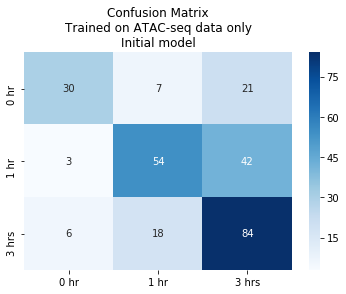

In [116]:
make_confusion_matrix_DEX(Y_atac_test, y_atac_pred, subtitle='Trained on ATAC-seq data only\nInitial model')

In [117]:
''' Evaluate model trained ONLY on RNA-seq input '''
y_rna_pred = predict_one_hot(X_rna_test, model_dir='models/best_rna_model_pp_fs')
y_rna_sm = predict(X_rna_test, model_dir='models/best_rna_model_pp_fs')

In [118]:
''' Get metrics for RNA-seq'''
print(f'Accuracy: {accuracy(Y_rna_test, y_rna_pred)}')
print(f'Precision: {precision(Y_rna_test, y_rna_pred)}')
print(f'Recall: {precision(Y_rna_test, y_rna_pred)}')

Accuracy: 0.9647798538208008
Precision: 0.947169840335846
Recall: 0.947169840335846


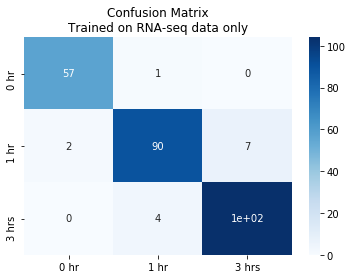

In [119]:
make_confusion_matrix_DEX(Y_rna_test, y_rna_pred, subtitle='Trained on RNA-seq data only')

In [120]:
''' Evaluate model trained on bimodal input (concatenation of ATAC + RNA) '''
y_bimodal_pred = predict_one_hot(X_bimodal_test, model_dir='models/best_bimodal_model_pp_fs')
y_bimodal_sm = predict(X_bimodal_test, model_dir='models/best_bimodal_model_pp_fs')

In [121]:
''' Get metrics using bimodal input '''
print(f'Accuracy: {accuracy(Y_bimodal_test, y_bimodal_pred)}')
print(f'Precision: {precision(Y_bimodal_test, y_bimodal_pred)}')
print(f'Recall: {precision(Y_bimodal_test, y_bimodal_pred)}')

Accuracy: 0.9597484469413757
Precision: 0.9396226406097412
Recall: 0.9396226406097412


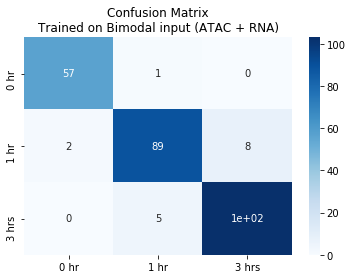

In [122]:
make_confusion_matrix_DEX(Y_bimodal_test, y_bimodal_pred, subtitle='Trained on Bimodal input (ATAC + RNA)')

In [123]:
''' Evaluate model trained on bimodal input (concatenation of ATAC + RNA) '''
y_bi_low_pred = predict_one_hot(X_bi_low_test, model_dir='models/best_bi_low_model_pp_fs')
y_bi_low_sm = predict(X_bi_low_test, model_dir='models/best_bi_low_model_pp_fs')

In [128]:
X_bi_low_train.shape

TensorShape([2376, 52761])

In [124]:
''' Get metrics using bimodal input '''
print(f'Accuracy: {accuracy(Y_bi_low_test, y_bi_low_pred)}')
print(f'Precision: {precision(Y_bi_low_test, y_bi_low_pred)}')
print(f'Recall: {precision(Y_bi_low_test, y_bi_low_pred)}')

Accuracy: 0.6150943636894226
Precision: 0.4226415157318115
Recall: 0.4226415157318115


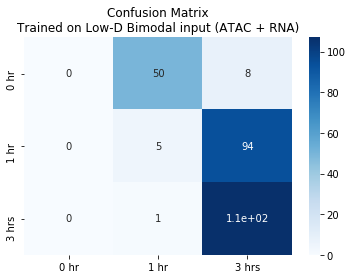

In [125]:
make_confusion_matrix_DEX(Y_bi_low_test, y_bi_low_pred, subtitle='Trained on Low-D Bimodal input (ATAC + RNA)')

In [127]:
''' Export training and test sets '''
from helpers import *

# create .pkl file names
root = os.getcwd()
pkl_path = os.path.join(root, 'data', 'sci-CAR', 'pkl_files')
pkl_atac = os.path.join(pkl_path, 'atac_pp_fs_.pkl')
pkl_rna = os.path.join(pkl_path, 'rna_pp_fs_.pkl')
pkl_bimodal = os.path.join(pkl_path, 'bimodal_pp_fs.pkl')
pkl_bi_low = os.path.join(pkl_path, 'bi_low_pp_fs.pkl')

# save training and test sets as pickle files
atac_data = (X_atac_train, X_atac_test)
write_zipped_pickle(atac_data, pkl_atac)
print('atac data saved')

rna_data = (X_rna_train, X_rna_test)
write_zipped_pickle(rna_data, pkl_rna)
print('rna data saved')

bimodal_data = (X_bimodal_train, X_bimodal_test)
write_zipped_pickle(bimodal_data, pkl_bimodal)
print('bimodal data saved')

bi_low_data = (X_bi_low_train, X_bi_low_test)
write_zipped_pickle(bi_low_data, pkl_bi_low)
print('bi_low data saved')

atac data saved
rna data saved
bimodal data saved
bi_low data saved
